# Kepler Problem with Manifold Projection

The purpose of this example is to show how ComponentArrays can be useful even with problems that aren't deeply nested. This example comes from the <i>Manifold Projection</i> section of [this tutorial](https://tutorials.sciml.ai/html/models/05-kepler_problem.html) by Yingbo Ma and Chris Rackauckas. To best see the benefits of ComponentArrays, open up the original tutorial and this one side-by-side and follow the along with both, noting the syntax changes between the two.

First, we will run the same 2D version as the original tutorial, then we'll rerun everything in 3D. Since the initial conditions and initial first integrals are ComponentArrays rather than flat arrays, it is almost no extra work to change from 2D to 3D as the position and momentum vectors are passed along by name rather than by their indices. The only thing we have to change for 3D is the calculation of the angular momentum, since it is a vector for 3D rather than a scalar. The <i>First Integrals</i> plot uses the magnitude of the momentum vector since momentum is no longer scalar.

In [1]:
using ComponentArrays
using DiffEqCallbacks
using ForwardDiff
using LinearAlgebra
using OrdinaryDiffEq
using Parameters: @unpack
using Plots; gr();
using Rotations

In [2]:
# We need this to deal with the fact that cross products are the worst
maybecross(x, y) = length(x)==3 ? cross(x,y) : cross([x..., 0],[y...,0])[3]

H(q, p) = norm(p)^2/2 - inv(norm(q))
L(q, p) = maybecross(q, p)

pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-H(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> H(q, p), p)

qdot (generic function with 1 method)

In [3]:
initial_position = [0.4, 0]
initial_velocity = [0.0, 2]
ic = CArray(p=initial_velocity, q=initial_position)

initial_first_integrals = CArray(H=H(ic.q, ic.p), L=L(ic.q, ic.p));
tspan = (0,20.)
dt = 1//5

1//5

In [4]:
function plot_orbit(sol)
    idx = getaxes(sol[1])[1][:q][1]
    plot(sol, vars=(idx...,), lab=nothing, title="Kepler Problem Solution")
end

function plot_first_integrals(sol, H, L)
    plot(sol.t, initial_first_integrals.H.-map(u->H(u.q,u.p), sol.u), lab="Energy variation", title="First Integrals")
    plot!(sol.t, norm.([initial_first_integrals.L].-map(u->L(u.q,u.p), sol.u)), lab="Angular momentum variation")
end

analysis_plot(sol, H, L) = plot(plot_orbit(sol), plot_first_integrals(sol, H, L))

analysis_plot (generic function with 1 method)

## 2D

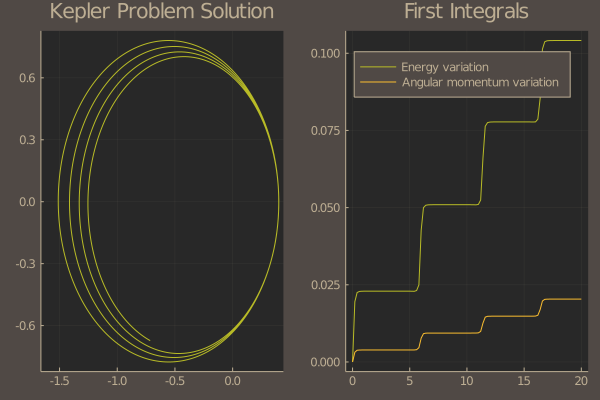

In [5]:
function hamiltonian(D,u,params,t)
    @unpack q, p = u
    qdot(D.q, p, q, params, t)
    pdot(D.p, p, q, params, t)
end

prob = ODEProblem(hamiltonian, ic, tspan)

function run_ham(prob)
    sol = solve(prob, RK4(), dt=dt, adaptive=false)
    analysis_plot(sol, H, L)
end
run_ham(prob)

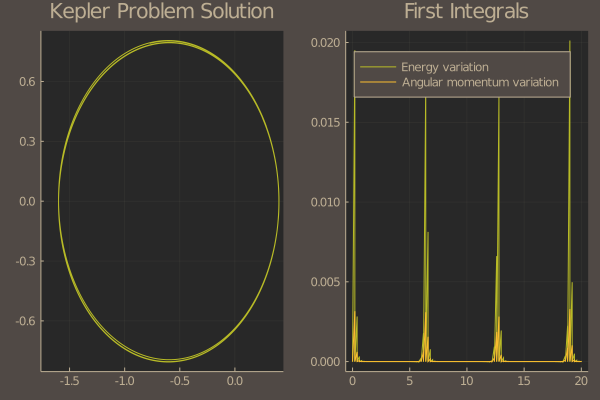

In [6]:
function first_integrals_manifold(residual,u)
    @unpack p, q = u
    residual.q .= initial_first_integrals.H - H(q, p)
    residual.p .= initial_first_integrals.L - L(q, p)
end

function run_int(prob)
    cb = ManifoldProjection(first_integrals_manifold)
    sol_int_man = solve(prob, RK4(), dt=dt, adaptive=false, callback=cb)
    analysis_plot(sol_int_man, H, L)
end
run_int(prob)

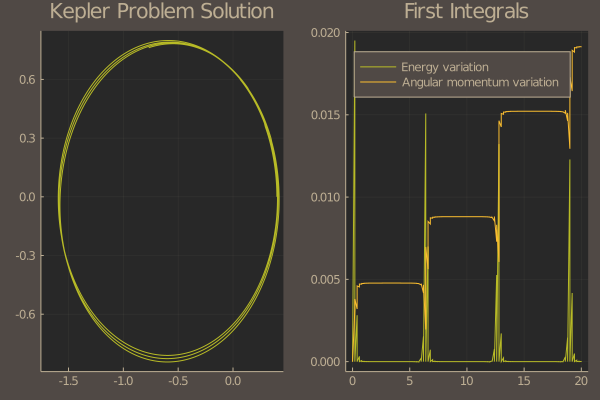

In [7]:
function energy_manifold(residual,u)
    @unpack p, q = u
    residual.q .= initial_first_integrals.H - H(q, p)
    residual.p .= 0
end

function run_energy(prob)
    energy_cb = ManifoldProjection(energy_manifold)
    sol_energy_man = solve(prob, RK4(), dt=dt, adaptive=false, callback=energy_cb)
    analysis_plot(sol_energy_man, H, L)
end
run_energy(prob)

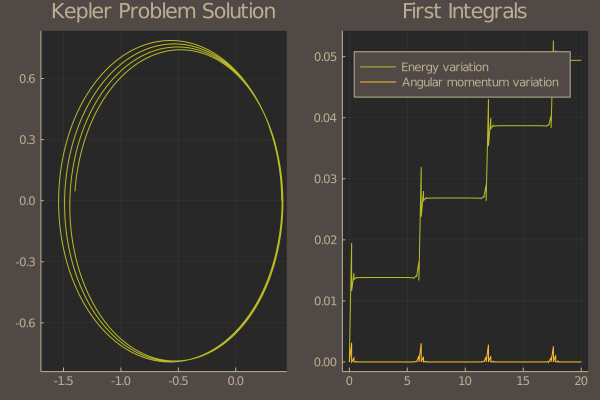

In [8]:
function angular_manifold(residual,u)
    @unpack p, q = u
    residual.q .= initial_first_integrals.L - L(q, p)
    residual.p .= 0
end

function run_angular(prob)
    angular_cb = ManifoldProjection(angular_manifold)
    sol_angle_man = solve(prob, RK4(), dt=dt, adaptive=false, callback=angular_cb)
    analysis_plot(sol_angle_man, H, L)
end
run_angular(prob)

## 3D

In [9]:
R = RotXY(π/4, π/4);

initial_position = [0.4, 0, 0]
initial_velocity = [0.0, 2, 0]
ic = CArray(p=R*initial_velocity, q=R*initial_position)
initial_first_integrals = CArray(H=H(ic.q, ic.p), L=L(ic.q, ic.p))

prob = ODEProblem(hamiltonian, ic, tspan);

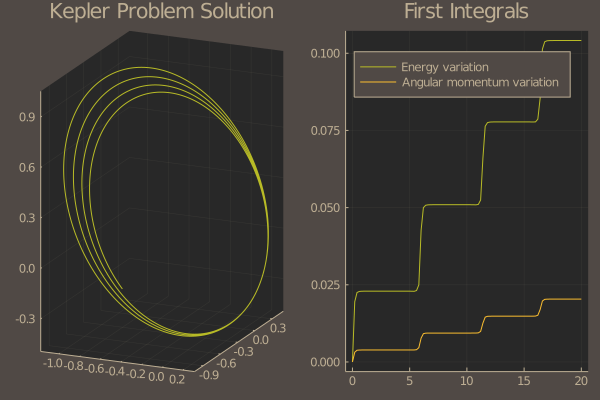

In [10]:
run_ham(prob)

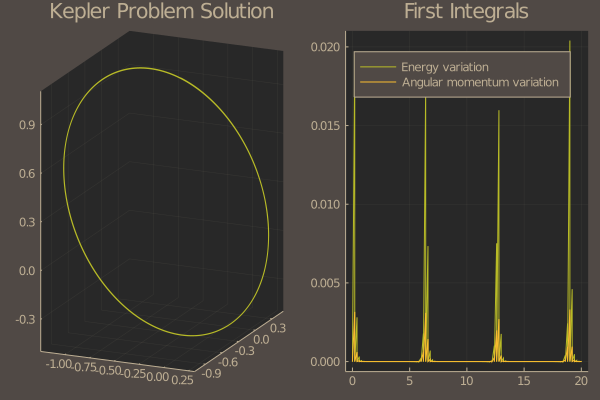

In [11]:
run_int(prob)

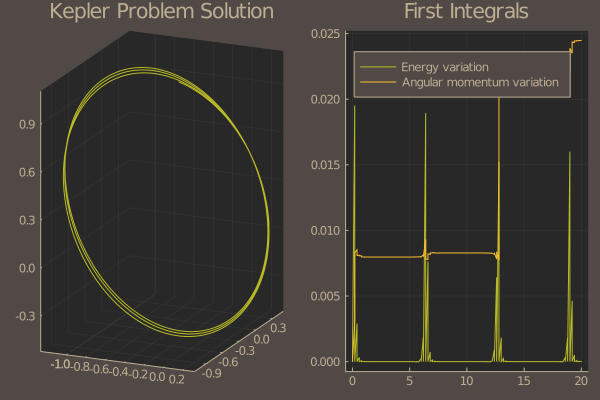

In [12]:
run_energy(prob)

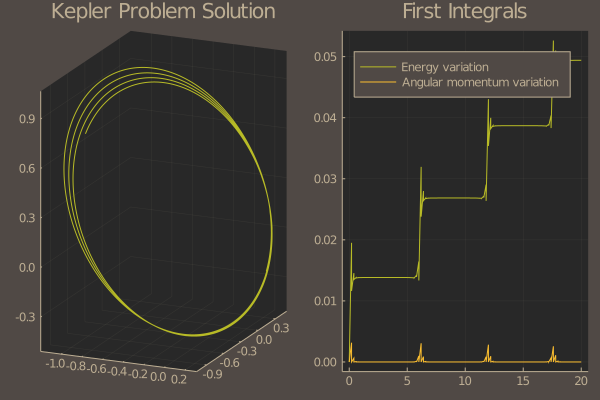

In [13]:
run_angular(prob)